# Cifar 10 

## Setup

### Imports

In [13]:
from functools import reduce

import numpy as np
import plotly.io as pio
from numpy import ndarray
import plotly.express as px
from numpy import array_split as split

from optimizers import Adam
from metrics import accuracy
from constants import MAX_NB_SAMPLES
from losses import BinaryCrossentropy
from cifar_10_dataset_loading import load_cifar_10
from layers import Convolutional, Linear, Relu, BatchNorm, Flatten, Softmax, MaxPool, Layer, LeakyRelu

In [14]:
pio.renderers.default = "jupyterlab+png"

### Data extraction

In [15]:
x_train, y_train, x_test, y_test = load_cifar_10()

In [16]:
classes = y_train.argmax(axis=1)

In [17]:
# Change range from [0, 255] to [-1, 1]
x_train = x_train / 255  
x_train.dtype

dtype('float64')

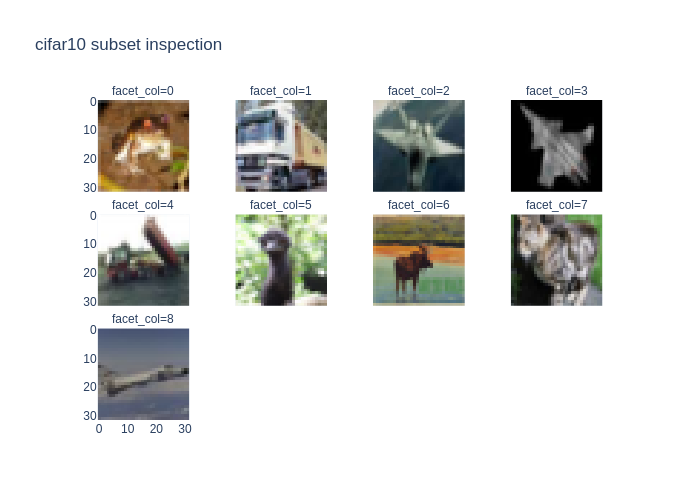

In [18]:
IMGS_IDX = [0, 1, 5673, 5494, 2, 55, 66, 776, 564]
x = x_train[IMGS_IDX]
y = y_train[IMGS_IDX]
px.imshow(x, facet_col=0, facet_col_wrap=4, title="cifar10 subset inspection")

In [19]:
NB_SAMPLES_PER_CLASS = 1000
NB_CLASSES = 10

class_masks = y_train.argmax(1, keepdims=True) == np.arange(NB_CLASSES)
take_first_n_of_class = lambda data, class_idx: data[class_masks[:, class_idx]][:NB_SAMPLES_PER_CLASS]
take_first_n_of_each_class = lambda data: np.concatenate([take_first_n_of_class(data, class_idx) for class_idx in range(NB_CLASSES)], axis=0)
x_train_subset = take_first_n_of_each_class(x_train)
y_train_subset = take_first_n_of_each_class(y_train)
x_train_subset.shape

KeyboardInterrupt: 

## Fitting cifar10

### Model declaration

In [8]:
def create_nn() -> list[Layer]:
    return [
        Convolutional((10, 7, 7, 3)),
        BatchNorm(),
        Relu(),
        MaxPool((2, 2)),
        Flatten(),
        Linear(1690, 300),
        LeakyRelu(),
        Linear(300, y.shape[1]),
        Softmax(),
    ]

### Optimizer

In [9]:
def create_optimizer(nn:list[Layer]) -> Adam:
    return Adam(
        nn,
        x_train,
        y_train,
        BinaryCrossentropy(),
        starting_lr=0.015,
        lr_decay=0.0001,
        momentum_weight=0.8,
        ada_grad_weight=0.999,
        l2_weight=0.0,
    )

In [10]:
NB_TEST_BATCHES = int(np.ceil(len(x_test) / MAX_NB_SAMPLES))
loss = BinaryCrossentropy()

def test_accuracy(metric_line:dict, nn:list[Layer], **_) -> dict:
    y_test_pred = []
    for x_test_subset in split(x_test, NB_TEST_BATCHES):
        y_test_pred.append(reduce(lambda x, l: l.forward(x), nn, x_test_subset))
    y_test_pred = np.concatenate(y_test_pred)
    metric_line["test_accuracy"] =  np.mean(y_test_pred.argmax(1) == y_test.argmax(1))
    metric_line["test_loss"] = loss.forward(y_test_pred, y_test)
    return metric_line


### Training

In [11]:
nn = create_nn()
first_optimizer = create_optimizer(nn)

In [12]:
bad_training_stats = (
    first_optimizer
    .optimize_nn(
        epochs=35,
        batch_size=500,
        metrics=[accuracy, test_accuracy],
        plt_x="epoch",
        plt_ys=[
            "loss",
            "accuracy",
            "test_accuracy",
            "test_loss",
            "learning_rate",
        ],
        height=600,
    )
)

FigureWidget({
    'data': [{'hovertemplate': 'variable=loss<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'loss',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '99a9def7-1496-4ccc-92f2-f0e30a5af3ab',
              'x': array([0]),
              'xaxis': 'x5',
              'y': array([0.3250852]),
              'yaxis': 'y5'},
             {'hovertemplate': 'variable=accuracy<br>epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'accuracy',
              'orientation': 'v',
              'showlegend': True,
      

Caught KeyboardInterrupt exception, returning training metrics.


In [20]:
test_accuracy({}, nn)

{'test_accuracy': np.float64(0.3074),
 'test_loss': np.float64(0.2805231878394473)}

### Inspecting the trained model

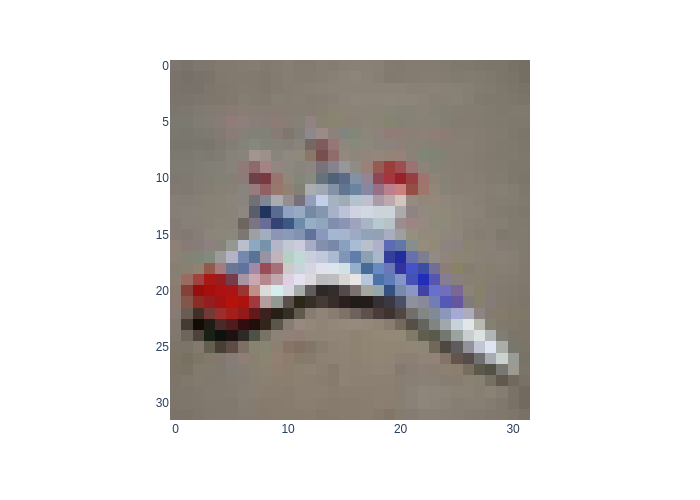

In [21]:
TARGET_IMG = 30
px.imshow(x_train[TARGET_IMG])

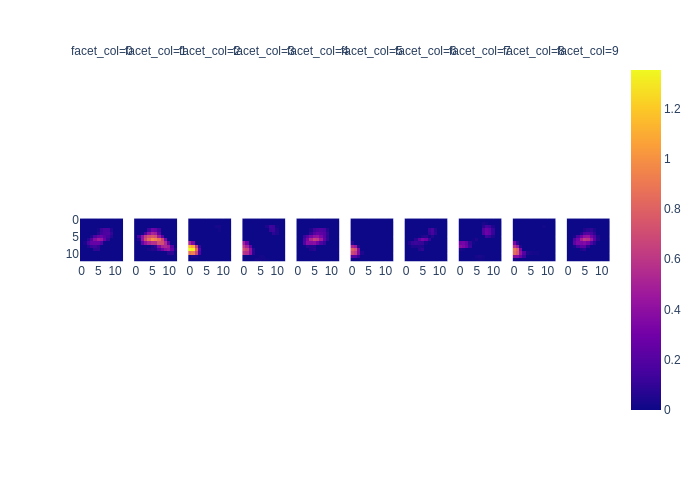

In [22]:
imgs = x_train[:1000]
convs =  reduce(lambda x, l: l.forward(x), nn[:4], imgs) #nn[1].forward(nn[0].forward(img))
convs.shape
px.imshow(convs[TARGET_IMG], facet_col=2, facet_col_wrap=10)

In [23]:
convs.sum(axis=(0, 1, 2))

array([32111.6383575 , 30699.11710184, 26908.29922216, 30331.28295851,
       31989.08823763, 26132.04711765, 27440.72312157, 32822.2326105 ,
       39425.09879529, 31102.05584458])

In [24]:
activations = reduce(lambda x, l: l.forward(x), nn[:7], imgs) #nn[1].forward(nn[0].forward(img))
activations.sum(axis=(0))

array([-1.20195478e+02, -1.25015417e+02, -1.84601649e+02, -1.86088371e+02,
        1.60229777e+02, -7.25425683e+01, -8.62610263e+01, -1.26348398e+02,
       -9.72008854e+01, -6.25493252e+01,  9.89383890e+01, -1.42763649e+02,
       -1.15027644e+02, -1.19476584e+02, -1.13631171e+02, -1.11887042e+02,
       -1.27404474e+02, -7.84281009e+01, -1.81209303e+02, -1.43048045e+02,
       -1.78217616e+02,  2.91647574e+03, -1.31215824e+02, -1.13245298e+02,
       -6.95578195e+01, -1.31756265e+02, -1.40148908e+02, -1.20854923e+02,
       -1.03386872e+02,  7.79644363e+02, -1.42694485e+02, -1.55959872e+02,
       -1.39954061e+02, -1.28666264e+02, -1.20176756e+02, -1.20776235e+02,
       -1.45484380e+02,  3.33977439e+01, -9.69479853e+01, -5.38139417e+01,
       -1.26609715e+02, -1.22030644e+02, -1.13365335e+02, -1.13194871e+02,
       -1.98126044e+02, -6.42413586e+01, -1.86097753e+02, -8.76589053e+01,
       -1.30424087e+02, -7.12899785e+01, -1.45508396e+01, -1.32010392e+02,
        1.95263333e+03, -

In [25]:
convs[[250]].shape

(1, 13, 13, 10)

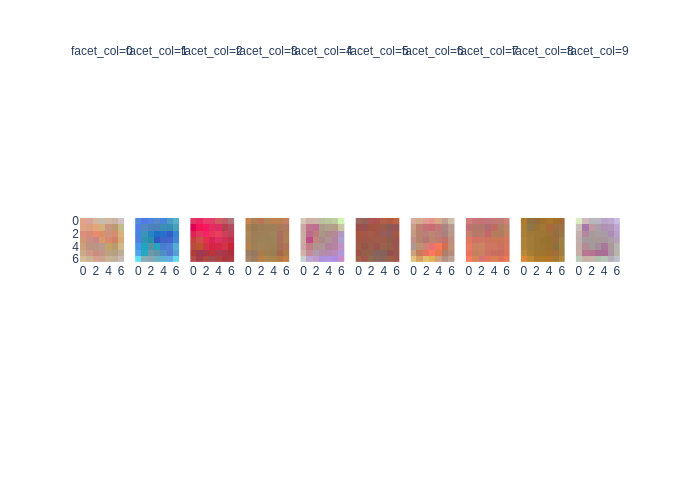

In [26]:
def min_max_normalize(arr:np.ndarray, axis:tuple) -> np.ndarray:
    return (arr - arr.min(axis, keepdims=True)) / (arr.max(axis, keepdims=True) - arr.min(axis, keepdims=True))

MIN = nn[0].kernels.min()
MAX = nn[0].kernels.max()
normed_kernels = (nn[0].kernels - MIN) / (MAX - MIN)
normed_kernels.shape

px.imshow(normed_kernels, facet_col=0, facet_col_wrap=10)

In [27]:
nn[0].biases

array([[[[-1.74582055e-11, -1.94787953e-11, -2.45241359e-12,
           2.34985050e-11, -2.10898029e-12,  3.01306657e-11,
           6.36692657e-12,  1.13347949e-11, -1.65673111e-11,
          -2.46318108e-12]]]])

In [28]:
nn[1].gamma

array([[[[0.69260885, 0.68402262, 0.6971479 , 0.71282591, 0.69029645,
          0.67647933, 0.65845691, 0.70235144, 0.76765371, 0.69632771]]]])

In [29]:
nn[1].beta

array([[[[-0.28947369, -0.30271636, -0.30736937, -0.26575864,
          -0.29314423, -0.30799168, -0.32569963, -0.27961124,
          -0.20743394, -0.3167011 ]]]])

## Conclusion
